In [1]:
from sklearn import preprocessing
from collections import deque
from datetime import datetime
import random
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.python.keras.layers import CuDNNLSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

drive_path = f'drive/MyDrive/Colab Notebooks/crypto_prediction/model3/'

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# ratios = ["BTCUSDT", "ETHUSDT", "NANOUSDT"]
ratios = ["BTCUSDT", "LTCUSDT", "ETHUSDT", "BNBUSDT",
          "ADAUSDT", "BTTUSDT", "DASHUSDT", "XMRUSDT",
          "NANOUSDT", "DOGEUSDT", "XLMUSDT", "BCHUSDT"]
RATIO_TO_PREDICT = "BTCUSDT"

SEQ_LEN = 48
FUTURE_PERIOD_PREDICT = 1
EPOCHS = 40
BATCH_SIZE = 64
current_time = datetime.utcnow().strftime('%Y-%m-%d %H-%M-%S')
NAME = f"LSTM-{current_time}"

def construct_main_df(ratios):
    main_df = pd.DataFrame()
    # 'unix,date,symbol,open,high,low,close,Volume LTC,Volume USDT,tradecount'
    for ratio in ratios:
        dataset = f"{drive_path}data/Binance_{ratio}_1h.csv"
        df = pd.read_csv(dataset, nrows=None, skiprows=None, parse_dates=['date'], usecols=[0, 1, 2])  # todo
        df.set_index("date", inplace=True)

        if len(main_df) == 0:
            main_df = df
        else:
            main_df = main_df.join(df)

    # in this case it reduces main_df length to the length of pair with the smallest data
    main_df.dropna(how='any', inplace=True)

    # we determine targets by making ['future'] column with shifted rows,
    # and then if its price is higher than current day setting ['target'] to 1, and 0 otherwise
    main_df['future'] = main_df[f"{RATIO_TO_PREDICT}_close"].shift(-FUTURE_PERIOD_PREDICT)
    main_df['target'] = list(map(classify, main_df[f"{RATIO_TO_PREDICT}_close"], main_df["future"]))
    main_df.drop('future', 1, inplace=True)  # future column is no longer needed, used only to determine target column
    # rows with future = NaN also are dropped here
    return main_df

def classify(current, future):
    return 1 if float(future) > float(current) else 0

def split_main_df(main_df, train_split, validation_split, test_split):
    # [train train train train_index val val val val_index test test test_index]
    train_index = int(train_split * len(main_df))  # last indexes
    validation_index = int(train_index + validation_split * len(main_df))
    test_index = test_split  # we don't really need to use it, its always the last index

    train_df = main_df.iloc[:train_index]
    validation_df = main_df.iloc[train_index:validation_index]
    test_df = main_df.iloc[validation_index:]
    return train_df, validation_df, test_df

# percentage change and scaling
def preprocess_data(df):
    df = df.copy()  # fixes random SettingWithCopyWarning appearing with pct_change and preprocessing.scale
    for col in df.columns:
        if col != "target":
            df[col] = df[col].pct_change()  # converted to percentage change
            # example:
            # hour 1:00 close = 93.13, hour 2:00 close = 92.41, so
            # 93.13 + 93.13 * x = 92.41, x = -0.007731
            # so percentage change of 1.0 means doubling the price
            # first row (the oldest values) is being filled with NaN percentage, but we don't want to drop whole row yet
            # so we wait until loop ends (we will have whole row filled with nans)
    df.dropna(inplace=True)
    # print('b', df.shape, df.isnull().values.any())
    for col in df.columns:
        if col != "target":
            # scaling should be used after splitting to training and test set - leaks data from test set to training
            df[col] = preprocessing.scale(df[col].values)  # normalizes to [-1, +1]
            # df[col] = preprocessing.StandardScaler().fit_transform(df[col].values.reshape(-1, 1)) # it does the same
            # scales the data so it has mean = 0, standard deviation = 1, variance = 1
            # it can be checked before and after with e.g. print(df['BTCUSDT_close'].mean())  .std()  .var()

    sequential_data = []
    prev_days = deque(maxlen=SEQ_LEN)  # list of SEQ_LEN items, we append to it, as it exceed, it pops old values

    for i in df.values:
        prev_days.append([n for n in i[:-1]])  # set of price and volume features added (-1 so without target)
        if len(prev_days) == SEQ_LEN:
            sequential_data.append([np.array(prev_days), i[-1]])
    # print(len(sequential_data))
    # ok so the sequences are like this ([a, b, 1] is single prev_days) (* and ^ just to point where it goes):
    # [([[a, b] [c, d], [e, f]], 1*)   ([[c, d] [e, f] [g, h]], 1) ... ([[g, h], [i, j], [k, l]], 0^)]
    random.shuffle(sequential_data)


    buys = []  # list that will store our buy sequences and targets
    sells = []  # list that will store our sell sequences and targets

    for seq, target in sequential_data:  # iterate over the sequential data
        if target == 0:  # if it's a "not buy"
            sells.append([seq, target])  # append to sells list
        elif target == 1:  # otherwise if the target is a 1...
            buys.append([seq, target])  # it's a buy!

    random.shuffle(buys)  # shuffle the buys
    random.shuffle(sells)  # shuffle the sells

    lower = min(len(buys), len(sells))  # what's the shorter length?

    buys = buys[:lower]  # make sure both lists are only up to the shortest length.
    sells = sells[:lower]  # make sure both lists are only up to the shortest length.

    sequential_data = buys + sells  # concatenate lists
    random.shuffle(
        sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.

    x = []
    y = []

    for seq, target in sequential_data:
        x.append(seq)
        y.append(target)
    return np.array(x), np.array(y)

In [3]:
time0 = time.perf_counter()
main_df = construct_main_df(ratios)
print(main_df.shape)
time1 = time.perf_counter()
print(time1 - time0)

train_df, validation_df, test_df = split_main_df(main_df, train_split=0.6, validation_split=0.2, test_split=0.2)
print(train_df.shape, validation_df.shape, test_df.shape)
time2 = time.perf_counter()
print(time2 - time1)

train_x, train_y = preprocess_data(train_df)
validation_x, validation_y = preprocess_data(validation_df)
test_x, test_y = preprocess_data(test_df)
time3 = time.perf_counter()
print(train_x.shape, train_y.shape, validation_x.shape, validation_y.shape, test_x.shape, test_y.shape,)
print(time3 - time2)

(15737, 25)
0.4711706650000451
(9442, 25) (3147, 25) (3148, 25)
0.0005700589999833028
(9134, 48, 24) (9134,) (2940, 48, 24) (2940,) (3066, 48, 24) (3066,)
2.1966656359999774


In [4]:
def build_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
    # i cannot save CuDNNLSTM due to some error, not using it
    # model.add(CuDNNLSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(BatchNormalization())

    model.add(LSTM(128, input_shape=(train_x.shape[1:])))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())

    model.add(Dense(32, activation="relu"))
    model.add(Dropout(0.2))

    model.add(Dense(2, activation="softmax"))

    opt = tf.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6)
    # opt = tf.keras.optimizers.Adam()

    model.compile(loss = "sparse_categorical_crossentropy", 
                  optimizer=opt,
                  metrics=['accuracy'])

    print(model.summary())
    return model
model = build_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 48, 128)           78336     
_________________________________________________________________
dropout (Dropout)            (None, 48, 128)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 128)           512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 48, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 48, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 128)           512       
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               1

In [5]:
checkpoint = ModelCheckpoint(filepath=f"models/{NAME}", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') # saves only the best ones
earlystopping = EarlyStopping(monitor='val_loss', patience=4)
cb = [checkpoint, earlystopping]

history = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=(validation_x, validation_y),
        callbacks=cb)


Epoch 1/40
143/143 [==============================] - 13s 23ms/step - loss: 0.7907 - accuracy: 0.5310 - val_loss: 0.6946 - val_accuracy: 0.4980

Epoch 00001: val_accuracy improved from -inf to 0.49796, saving model to models/LSTM-2021-08-23 20-05-44


INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


Epoch 2/40
143/143 [==============================] - 2s 17ms/step - loss: 0.6907 - accuracy: 0.5473 - val_loss: 0.7004 - val_accuracy: 0.5177

Epoch 00002: val_accuracy improved from 0.49796 to 0.51769, saving model to models/LSTM-2021-08-23 20-05-44


INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


Epoch 3/40
143/143 [==============================] - 2s 17ms/step - loss: 0.6819 - accuracy: 0.5651 - val_loss: 0.6283 - val_accuracy: 0.6435

Epoch 00003: val_accuracy improved from 0.51769 to 0.64354, saving model to models/LSTM-2021-08-23 20-05-44


INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


Epoch 4/40
143/143 [==============================] - 2s 17ms/step - loss: 0.6284 - accuracy: 0.6156 - val_loss: 0.6218 - val_accuracy: 0.7037

Epoch 00004: val_accuracy improved from 0.64354 to 0.70374, saving model to models/LSTM-2021-08-23 20-05-44


INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


Epoch 5/40
143/143 [==============================] - 2s 17ms/step - loss: 0.6344 - accuracy: 0.6056 - val_loss: 0.5704 - val_accuracy: 0.7007

Epoch 00005: val_accuracy did not improve from 0.70374
Epoch 6/40
143/143 [==============================] - 2s 17ms/step - loss: 0.5978 - accuracy: 0.6362 - val_loss: 0.5423 - val_accuracy: 0.7170

Epoch 00006: val_accuracy improved from 0.70374 to 0.71701, saving model to models/LSTM-2021-08-23 20-05-44


INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


Epoch 7/40
143/143 [==============================] - 2s 17ms/step - loss: 0.5774 - accuracy: 0.6511 - val_loss: 0.5440 - val_accuracy: 0.7323

Epoch 00007: val_accuracy improved from 0.71701 to 0.73231, saving model to models/LSTM-2021-08-23 20-05-44


INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


Epoch 8/40
143/143 [==============================] - 2s 17ms/step - loss: 0.5530 - accuracy: 0.6632 - val_loss: 0.5340 - val_accuracy: 0.7252

Epoch 00008: val_accuracy did not improve from 0.73231
Epoch 9/40
143/143 [==============================] - 2s 17ms/step - loss: 0.5499 - accuracy: 0.6642 - val_loss: 0.5367 - val_accuracy: 0.7330

Epoch 00009: val_accuracy improved from 0.73231 to 0.73299, saving model to models/LSTM-2021-08-23 20-05-44


INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


Epoch 10/40
143/143 [==============================] - 3s 18ms/step - loss: 0.5401 - accuracy: 0.6751 - val_loss: 0.5112 - val_accuracy: 0.7333

Epoch 00010: val_accuracy improved from 0.73299 to 0.73333, saving model to models/LSTM-2021-08-23 20-05-44


INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


Epoch 11/40
143/143 [==============================] - 3s 19ms/step - loss: 0.5340 - accuracy: 0.6775 - val_loss: 0.6029 - val_accuracy: 0.7456

Epoch 00011: val_accuracy improved from 0.73333 to 0.74558, saving model to models/LSTM-2021-08-23 20-05-44


INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


Epoch 12/40
143/143 [==============================] - 3s 18ms/step - loss: 0.5349 - accuracy: 0.6846 - val_loss: 0.5104 - val_accuracy: 0.7388

Epoch 00012: val_accuracy did not improve from 0.74558
Epoch 13/40
143/143 [==============================] - 3s 18ms/step - loss: 0.5291 - accuracy: 0.6833 - val_loss: 0.5159 - val_accuracy: 0.7378

Epoch 00013: val_accuracy did not improve from 0.74558
Epoch 14/40
143/143 [==============================] - 3s 18ms/step - loss: 0.5258 - accuracy: 0.6866 - val_loss: 0.5121 - val_accuracy: 0.7422

Epoch 00014: val_accuracy did not improve from 0.74558
Epoch 15/40
143/143 [==============================] - 2s 17ms/step - loss: 0.5268 - accuracy: 0.6813 - val_loss: 0.5140 - val_accuracy: 0.7357

Epoch 00015: val_accuracy did not improve from 0.74558
Epoch 16/40
143/143 [==============================] - 2s 17ms/step - loss: 0.5207 - accuracy: 0.6915 - val_loss: 0.5407 - val_accuracy: 0.7466

Epoch 00016: val_accuracy improved from 0.74558 to 0.74

INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


INFO:tensorflow:Assets written to: models/LSTM-2021-08-23 20-05-44/assets


Trained model:
        loss  accuracy  val_loss  val_accuracy
15  0.520694  0.691482  0.540717      0.746599 



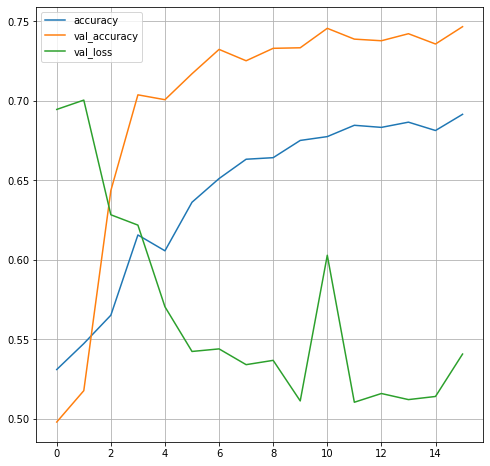

In [7]:
def plot_history(history):
        hist_df = pd.DataFrame(history.history)
        print(f'Trained model:')
        print(hist_df.tail(1), '\n')
        hist_df_short = hist_df[['accuracy', 'val_accuracy', 'val_loss']]
        hist_df_short.plot(figsize=(8,8), grid=True)

plot_history(history)

In [8]:
model_path = f'{drive_path}models/{NAME}'
model.save(model_path)

model = keras.models.load_model(model_path)
score = model.evaluate(test_x, test_y, verbose=10)  # evaluate against unseen test data
print("TEST LOSS:", score[0])
print("TEST ACCURACY:", score[1])

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/crypto_prediction/model3/models/LSTM-2021-08-23 20-05-44/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/crypto_prediction/model3/models/LSTM-2021-08-23 20-05-44/assets


TEST LOSS: 0.6933889985084534
TEST ACCURACY: 0.5228310227394104
